# Predicting used car prices

In this notebook, I'll work with the [Kaggle](https://www.kaggle.com/avikasliwal/used-cars-price-prediction) dataset about used cars and their prices. The notebook first includes exploration of the dataset followed by prediction of prices.

## Import libraries

I'll import `datetime` to handle year, `numpy` to work with arrays and `pandas` to read in the dataset files, `matplotlib` & `seaborn` for plotting and `sklearn` for various machine learning models.

In [1]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Read dataset

I'll read the dataset and get information about it.

In [2]:
dataset = pd.read_csv("data/dataset.csv")
dataset.head(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


Let's first split the dataset into train and test datasets.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], 
                                                    dataset.iloc[:, -1], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4213 entries, 4201 to 860
Data columns (total 13 columns):
Unnamed: 0           4213 non-null int64
Name                 4213 non-null object
Location             4213 non-null object
Year                 4213 non-null int64
Kilometers_Driven    4213 non-null int64
Fuel_Type            4213 non-null object
Transmission         4213 non-null object
Owner_Type           4213 non-null object
Mileage              4212 non-null object
Engine               4189 non-null object
Power                4189 non-null object
Seats                4185 non-null float64
New_Price            580 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 460.8+ KB


## Exploratory Data Analysis

Let's explore the various columns and draw information about how useful each column is. I'll also modify the test data based on training data.

### Index

The first column is the index for each data point and hence we can simply remove it.

In [5]:
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

### Name

Let's explore the various cars in the dataset.

In [6]:
X_train["Name"].value_counts()

Mahindra XUV500 W8 2WD             35
Maruti Swift VDI                   31
Maruti Ritz VDi                    26
Hyundai i10 Sportz                 25
Maruti Swift Dzire VDI             24
                                   ..
BMW X5 xDrive 30d M Sport           1
Mini Countryman Cooper D            1
Mitsubishi Lancer 1.5 SFXi          1
Hyundai i10 Magna Optional 1.1L     1
Mercedes-Benz CLA 200 CDI Style     1
Name: Name, Length: 1592, dtype: int64

As it appears, there are several cars in the dataset, some of them with a count higher than 1.
Sometimes the resale value of a car also depends on manufacturer of car and hence, I'll extract the manufacturer from this column and add it to the dataset.

In [7]:
make_train = X_train["Name"].str.split(" ", expand = True)
make_test = X_test["Name"].str.split(" ", expand = True)

In [8]:
X_train["Manufacturer"] = make_train[0]
X_test["Manufacturer"] = make_test[0]

Let's also confirm that there are no null values and identify all unique values.

Text(0, 0.5, 'Count of cars')

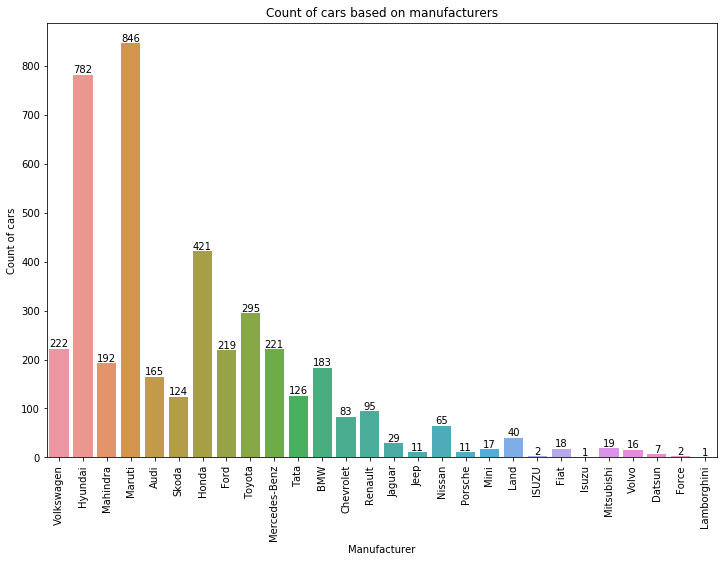

In [9]:
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = X_train)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

Maximum cars in the dataset are by the manufacturer **Maruti** and there are no null values.

I'll also drop the `Name` column.

In [10]:
X_train.drop("Name", axis = 1, inplace = True)
X_test.drop("Name", axis = 1, inplace = True)

### Location

Location should not be a determinant for the price of a car and I'll safely remove it.

In [11]:
X_train.drop("Location", axis = 1, inplace = True)
X_test.drop("Location", axis = 1, inplace = True)

### Year

Year has no significance on its own unless we try to extract how old a car is from this and see how its resale price may get affected.

In [12]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x : curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x : curr_time.year - x)

### Fuel_Type, Transmission,  and Owner_Type

All these columns are categorical columns which should be converted to dummy variables before being used.

### Kilometers_Driven

`Kilometers_Driven` is a numerical column with a certain range of values.

In [13]:
X_train["Kilometers_Driven"]

4201     77000
4383     19947
1779     70963
4020    115195
3248     58752
         ...  
3772     27000
5191      9000
5226    140000
5390     76414
860      98000
Name: Kilometers_Driven, Length: 4213, dtype: int64

The data range is really varied and the high values might affect prediction, thus, it is really important that scaling be applied to this column for sure.

## Mileage

This column defines the mileage of the car. We need to extract the numerical value out of each string and save it.

In [14]:
mileage_train = X_train["Mileage"].str.split(" ", expand = True)
mileage_test = X_test["Mileage"].str.split(" ", expand = True)

X_train["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
X_test["Mileage"] = pd.to_numeric(mileage_test[0], errors = 'coerce')

Let's check for missing values.

In [15]:
print(sum(X_train["Mileage"].isnull()))
print(sum(X_test["Mileage"].isnull()))

1
1


There is one missing value in each. I'll replace the missing value with the mean value of the column based on the training data.

In [16]:
X_train["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)
X_test["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)

### Engine, Power and Seats

The `Engine` values are defined in CC so I need to remove `CC` from the data. Similarly, `Power` has bhp, so I'll remove `bhp` from it. Also, as there are missing values in `Engine`, `Power` and `Seats`, I'll again replace them with the mean.

In [17]:
cc_train = X_train["Engine"].str.split(" ", expand = True)
cc_test = X_test["Engine"].str.split(" ", expand = True)
X_train["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')
X_test["Engine"] = pd.to_numeric(cc_test[0], errors = 'coerce')

bhp_train = X_train["Power"].str.split(" ", expand = True)
bhp_test = X_test["Power"].str.split(" ", expand = True)
X_train["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')
X_test["Power"] = pd.to_numeric(bhp_test[0], errors = 'coerce')

In [18]:
X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
X_test["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)

X_train["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)
X_test["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)

X_train["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)
X_test["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)

### New Price

As most of the values are missing, I'll drop this column altogether.

In [19]:
X_train.drop(["New_Price"], axis = 1, inplace = True)
X_test.drop(["New_Price"], axis = 1, inplace = True)

## Data Processing

Now that we have worked with the training data, let's create dummy columns for categorical columns before we begin training.

In [20]:
X_train = pd.get_dummies(X_train,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

In [21]:
X_test = pd.get_dummies(X_test,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

It might be possible that the dummy column creation would be different in test and train data, thus, I'd fill in all missing columns with zeros.

In [22]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

Finally, as the last step of data processing, I'll scale the data.

In [23]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

## Training and predicting

I'll create a **Linear Regression** model and a **Random Forest** model to train on the data and use it for future predictions.

In [24]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
r2_score(y_test, y_pred)

0.7008908549416721

In [25]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.8860868487769373

The **Random Forest** model performed the best with a R2 score of **0.88**.